In [1]:
import tensorflow as tf
import os

from assets.one_mask.data_generator import DR_Generator
from assets.one_mask.models import SMD_Unet 
from assets.one_mask.trainer import Trainer

In [2]:
masks = ['HardExudate_Masks', 'Hemohedge_Masks', 'Microaneurysms_Masks', 'SoftExudate_Masks']
mask_dir = '../data/FGADR/Seg-set'
mask_paths = [os.path.join(mask_dir, mask) for mask in masks]

generator_args = {
    'dir_path':'../data/FGADR/Seg-set/Original_Images/',
    'mask_path':mask_paths,
    'use_mask':True,
    'img_size':(512, 512),  
    'batch_size':4, # 8로 하면 바로 OOM 뜸
    'dataset':'FGADR', # FGADR or EyePacks
    'use_3channel':True,
    'CLAHE_args':None
}

tr_fgadr_gen = DR_Generator(start_end_index=(0, 1108), is_train=True, **generator_args)
val_fgadr_gen = DR_Generator(start_end_index=(1108, 1660), is_train=False, **generator_args)
ts_fgadr_gen = DR_Generator(start_end_index=(1660, 1840), is_train=False, **generator_args)

# tr_fgadr_gen = DR_Generator(start_end_index=(0, 1292), is_train=True, **generator_args)
# val_fgadr_gen = DR_Generator(start_end_index=(1292, 1476), is_train=False, **generator_args)
# ts_fgadr_gen = DR_Generator(start_end_index=(1476, 1842), is_train=False, **generator_args)

# tr_fgadr_gen = DR_Generator(start_end_index=(0, 30000), is_train=True, **generator_args)
# val_fgadr_gen = DR_Generator(start_end_index=(30000, 31000), is_train=False, **generator_args)

In [3]:
model = SMD_Unet(enc_filters=[64, 128, 256, 512, 1024], dec_filters=[512, 256, 64, 32], input_channel=3)
model.load_weights("../models/one_mask/New/4_pretraining_3channel_alpha01_lr0001/49")

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 

trainer_args = {
    'model':model,
    'epochs':50,
    'optimizer':optimizer,
    'for_recons':False,   # pretraining을 할지 말지 (true = recons만 학습 한다.)
    'alpha':0.1,           # loss를 구할때 mask_loss는 알파 * recons_loss + (1 - 알파 * mask_loss)
    'beta':None,
    'first_epoch':1,
    'file_name':"history/one_mask/New/4_1_pretraining_3channel_alpha01_lr00001.txt",
    'save_model_path':"../models/one_mask/New/4_1_pretraining_3channel_alpha01_lr00001",
    'add_noise':False
}
trainer = Trainer(**trainer_args)

trainer.train(train_dataset=tr_fgadr_gen,
              val_dataset=val_fgadr_gen
             )


Epoch 1/50
 528/1108 [=============>................] - ETA: 4:07 - train_loss: 0.4652 - mask_loss: 0.5168 - loss_recons: 7.9341e-04

# 모델 결과 시각화

In [ ]:
from assets.one_mask.utils import parse_history_text
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [ ]:
history = parse_history_text('history/one_mask/New/4_pretraining_3channel_alpha01_lr0001.txt')

plt.plot(history['epoch'], history['train_mask_loss'], label='train_mask_loss')
plt.plot(history['epoch'], history['val_mask_loss'], label='val_mask_loss')

plt.title('4_pretraining_3channel_alpha01_lr0001')
plt.legend()
plt.show()

In [ ]:
history = parse_history_text('history/one_mask/withoutCLAHE_withoutRecons_alpha00_lr0001.txt')

plt.plot(history['epoch'], history['train_mask_loss'], label='lr0.001')
plt.plot(history['epoch'], history['val_mask_loss'], label='lr0.001')


history = parse_history_text('history/one_mask/withoutCLAHE_withoutRecons_alpha00_lr00001.txt')

plt.plot(history['epoch'], history['train_mask_loss'], label='lr0.0001', linestyle='--')
plt.plot(history['epoch'], history['val_mask_loss'], label='lr0.0001', linestyle='--')

plt.title('lr')
plt.legend()
plt.show()

# 평가지표

In [1]:
from assets.evaluation.evaluate_result import evaluate_main

generator_type = 'train'  # 원하는 generator 타입 선택: 'train', 'validation', 또는 'test'
input_channel = 3         # 3channel은 3, 1channel은 1
use_3channel = True     # 3channel은 True, 1channel은 False
model_path = "../models/one_mask/4_pretraining_3channel_alpha01_lr0001/49"  # 모델 경로 지정
result_df = evaluate_main(generator_type, model_path, input_channel, use_3channel)

100%|██████████| 277/277 [05:56<00:00,  1.29s/it]

CSV 파일 저장 완료: assets/evaluation/evaluation_results_csv/4_pretraining_3channel_alpha01_lr0001_train_evaluation_result.csv


In [1]:
import pandas as pd

#result_df = pd.read_csv("assets/evaluation/evaluation_results_csv/4_pretraining_3channel_alpha01_lr0001_validation_evaluation_result.csv")
result_df = result_df["file_name"]
result_df = result_df.iloc[:5]
result_df

0    1221_3.png
1    1608_3.png
2    1452_3.png
3    1350_2.png
4    1440_2.png
Name: file_name, dtype: object

# Prediction 결과 시각화

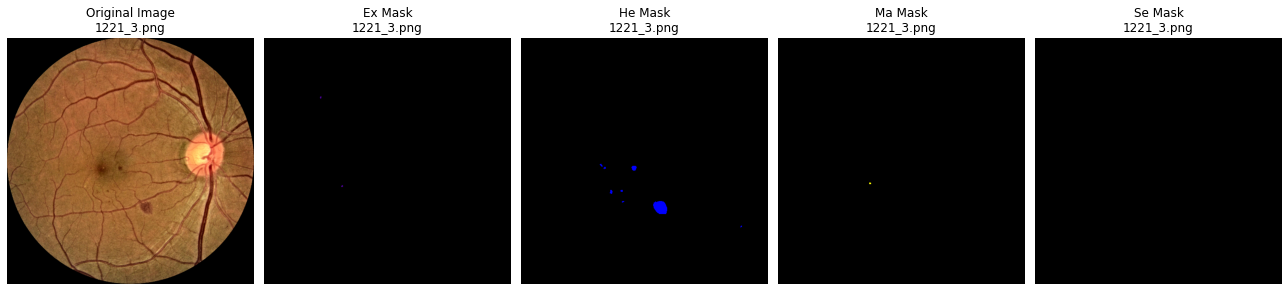

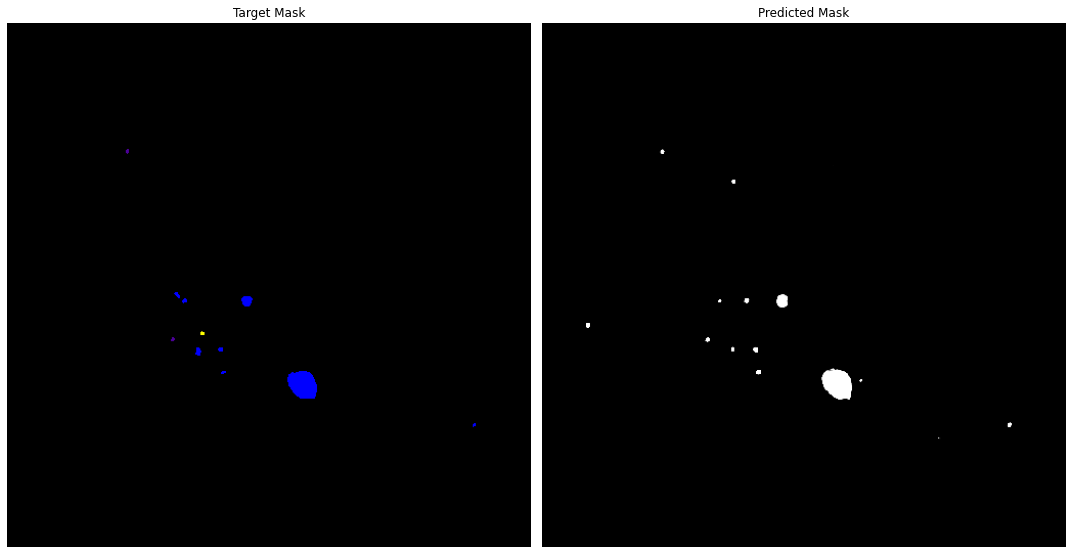

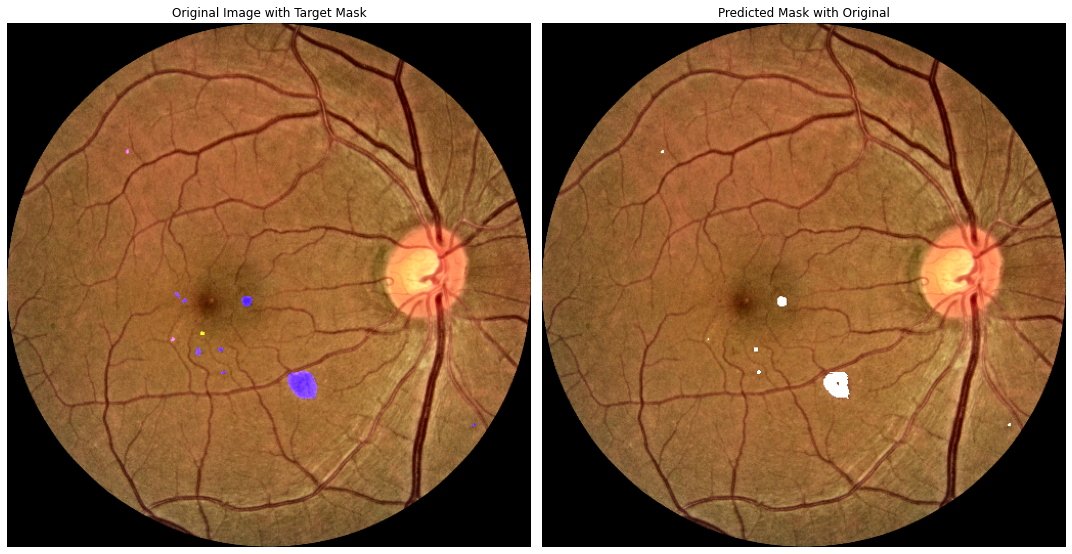

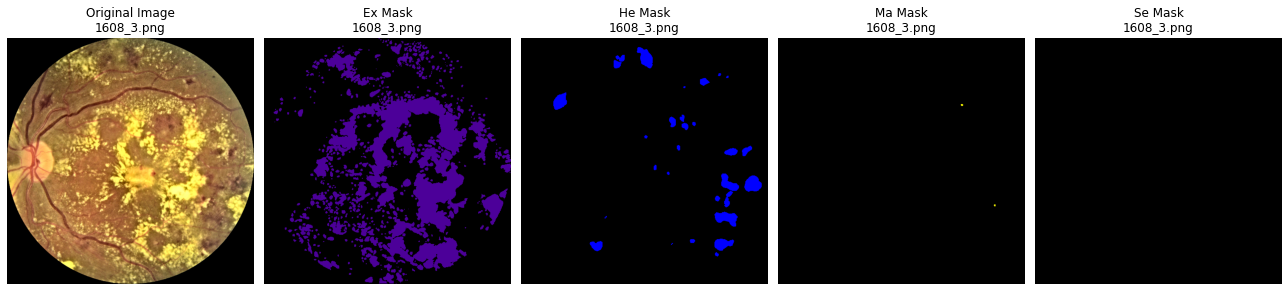

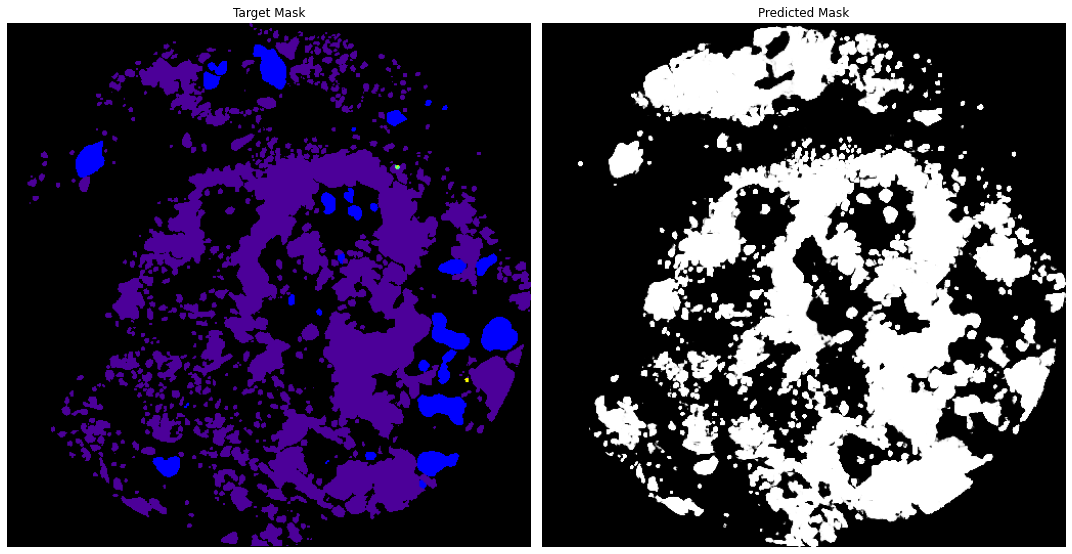

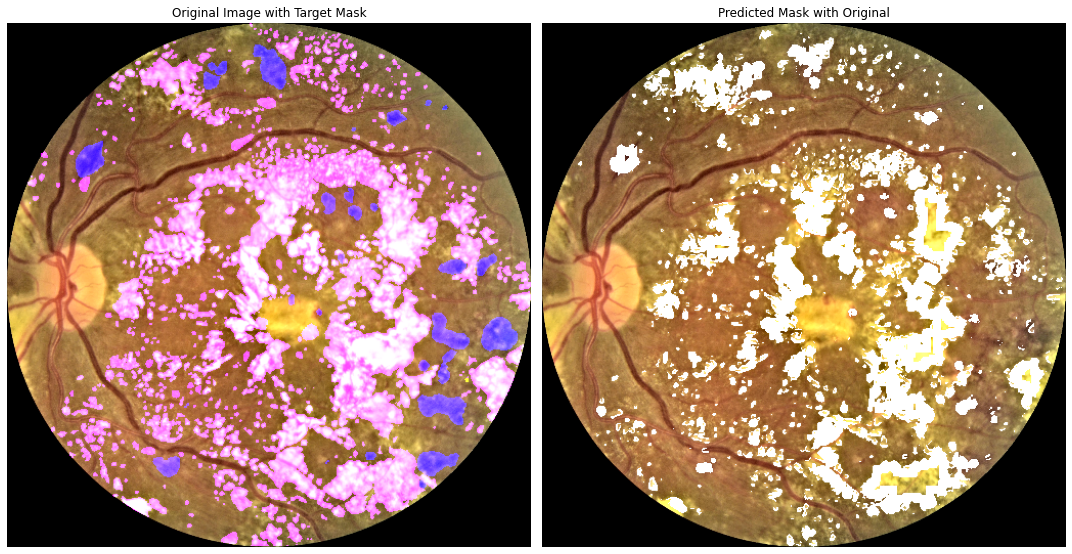

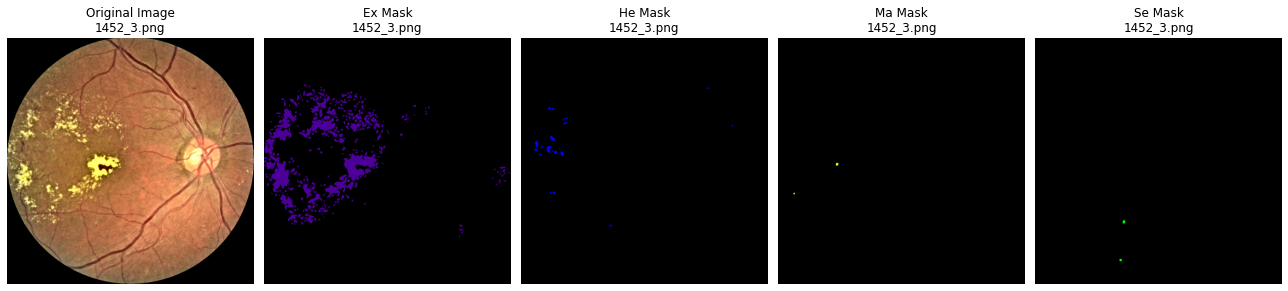

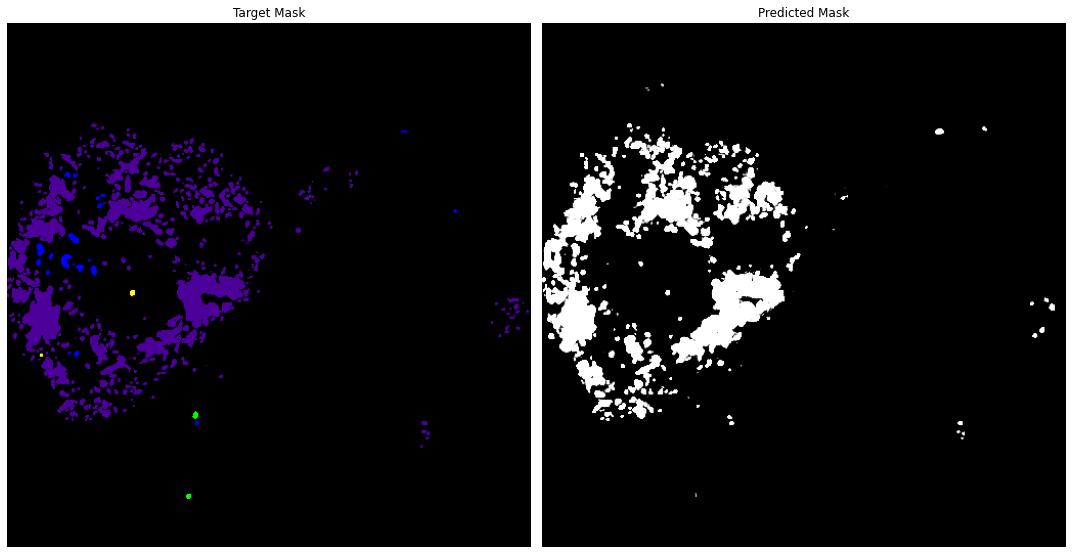

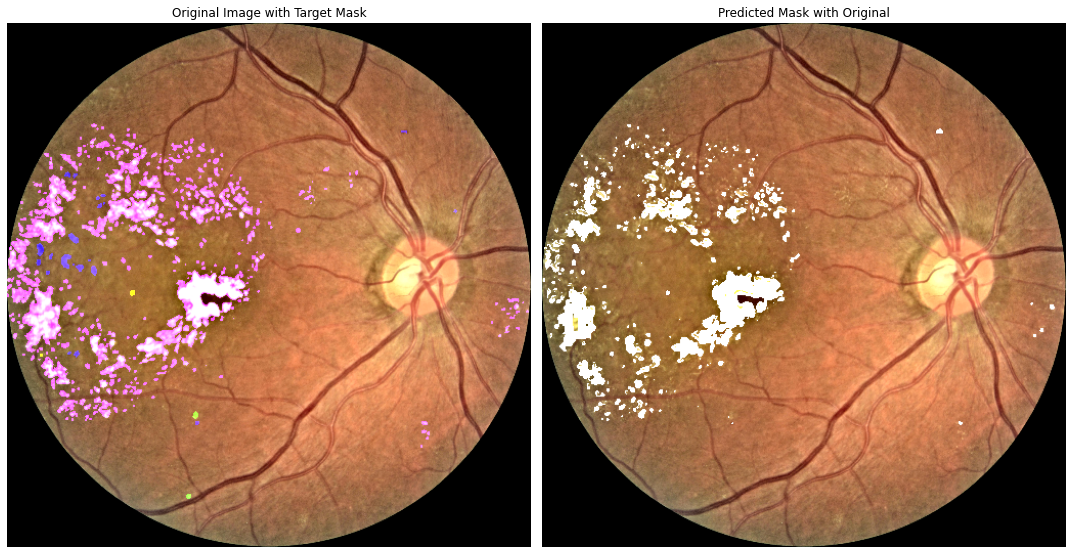

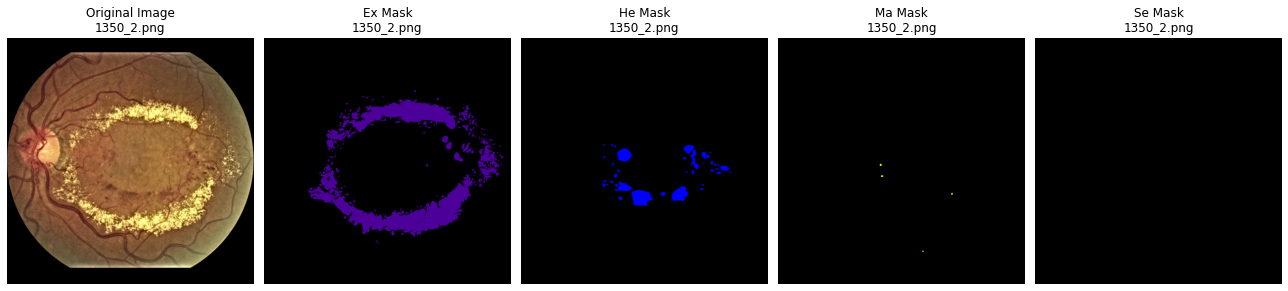

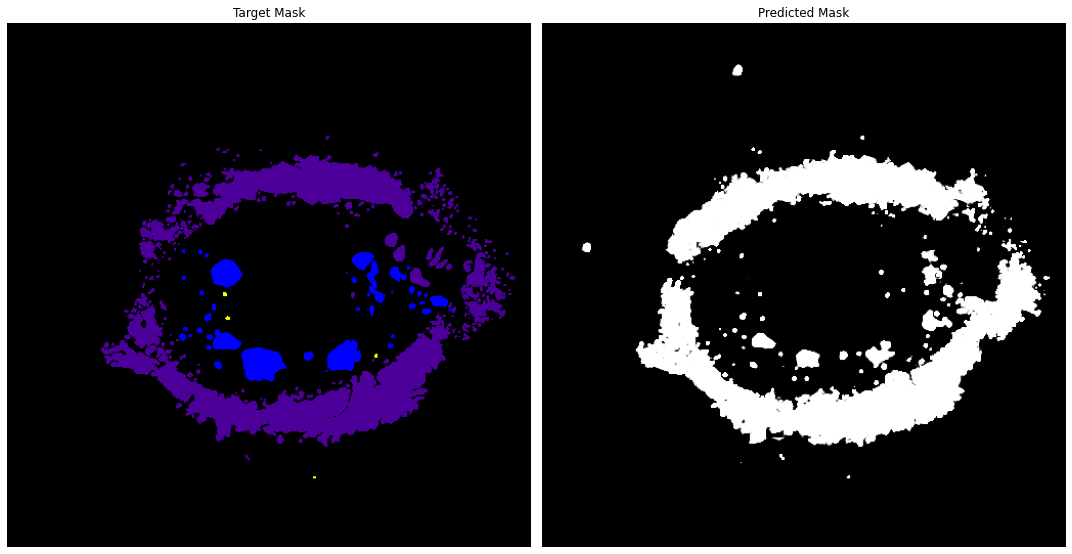

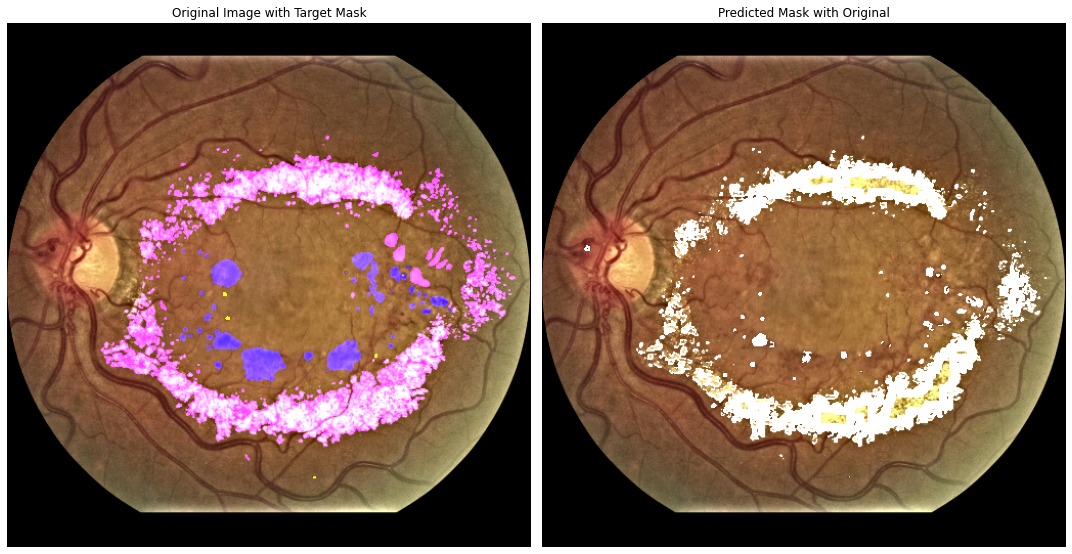

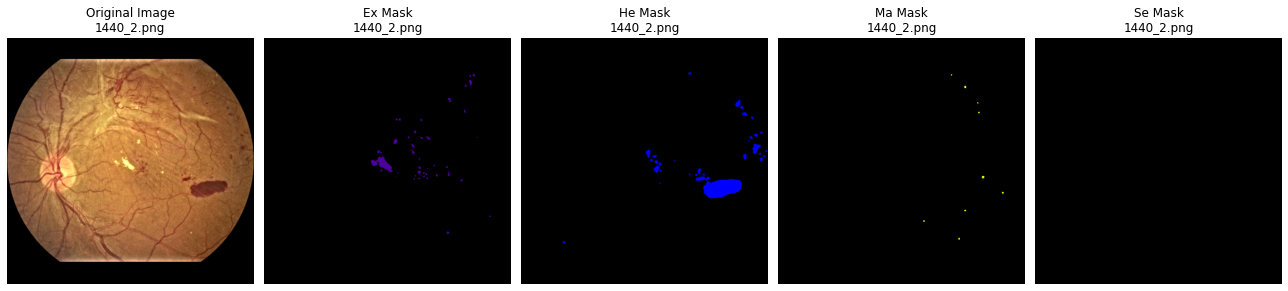

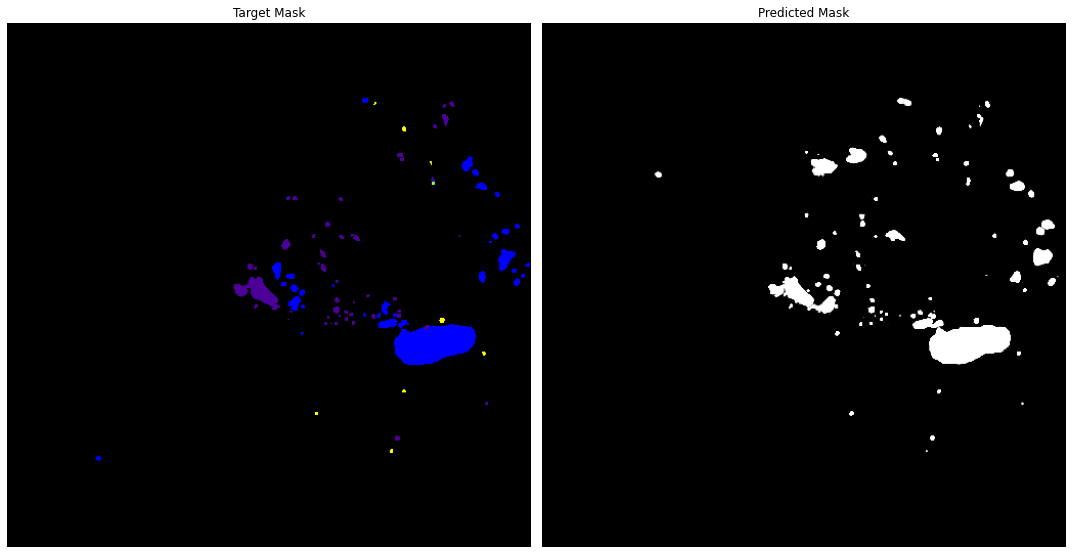

In [ ]:
from assets.evaluation.evaluation_visual import visualize_segmentation_results

#image_filenames = ["0381_1.png", "0311_1.png", "1134_1.png", "1181_3.png"]  # 원하는 이미지 파일명으로 수정
image_filenames = result_df

model_path = "../models/one_mask/4_pretraining_3channel_alpha01_lr0001/49"
visualize_segmentation_results(image_filenames, model_path)